```{contents}
```
## Conditional Graph 

A **Conditional Graph** in LangGraph is a **state-driven execution graph** where the **next node is chosen dynamically at runtime** based on the current **graph state**.
It allows LangGraph to model **decision-making workflows**, **branching logic**, **agent routing**, and **adaptive systems**.

---

### **1. Motivation and Intuition**

Traditional pipelines are **static**:

```
A → B → C → D
```

Real intelligent systems are **dynamic**:

```
        → B1 →
A → Decide        → C
        → B2 →
```

The decision of which path to follow depends on:

* User input
* Tool outputs
* Agent reasoning
* System constraints
* Environment feedback

LangGraph formalizes this through **conditional edges**.

---

### **2. Formal Definition**

A **conditional graph** is a directed graph where:

> **Edges are activated by predicates over the shared state**

The graph becomes a **runtime decision system** rather than a fixed pipeline.

---

### **3. Core Mechanism in LangGraph**

LangGraph uses **router functions** to control flow.



In [1]:

def router(state) -> str:
    """Router function that determines next node based on state.
    
    Returns:
        str: Label indicating which node to execute next
    """
    query = state.get("query", "").lower()
    
    if "weather" in query:
        return "weather"
    elif "calculate" in query or "compute" in query:
        return "compute"
    elif "search" in query:
        return "search"
    else:
        return "general"
    



This function returns a **label** that selects the next node.

```python
builder.add_conditional_edges(
    source_node="decide",
    condition=router,
    path_map={
        "search": "search_node",
        "compute": "compute_node",
        "final": "answer_node"
    }
)
```

---

### **4. Minimal Working Example**

```python
from langgraph.graph import StateGraph, END
from typing import TypedDict

class State(TypedDict):
    query: str
    answer: str

def decide(state):
    if "weather" in state["query"]:
        return "weather"
    return "general"

def weather_node(state):
    return {"answer": "It is sunny."}

def general_node(state):
    return {"answer": "General knowledge response."}

builder = StateGraph(State)

builder.add_node("decide", decide)
builder.add_node("weather", weather_node)
builder.add_node("general", general_node)

builder.set_entry_point("decide")

builder.add_conditional_edges("decide", decide, {
    "weather": "weather",
    "general": "general"
})

builder.add_edge("weather", END)
builder.add_edge("general", END)

graph = builder.compile()
```

---

### **5. Execution Flow**

```
User Input
   ↓
Decide Node
   ↓
Condition Function → Branch Selection
   ↓
Selected Node
   ↓
END
```

---

### **6. State-Driven Decision Model**

| Component         | Role                     |
| ----------------- | ------------------------ |
| State             | Holds facts & context    |
| Router            | Computes decision        |
| Conditional Edges | Enforce routing          |
| Nodes             | Perform specialized work |

This yields a **pure state machine**.

---

### **7. Production Use Cases**

| Scenario             | Benefit                   |
| -------------------- | ------------------------- |
| Tool routing         | Choose correct API        |
| Agent specialization | Delegate tasks            |
| Safety gating        | Block unsafe outputs      |
| Cost optimization    | Cheap vs expensive models |
| Fallback logic       | Graceful recovery         |
| Human approval       | Conditional intervention  |

---

### **8. Advanced Patterns**

#### **Hierarchical Routing**

```
High-Level Router
   ↓
Subgraph Router
   ↓
Execution Nodes
```

#### **Agent Delegation**

Supervisor → Worker A
Supervisor → Worker B
Supervisor → Worker C

#### **Failover Graph**

```
Try Primary → Success → END
      ↓
   Failure → Backup → END
```

---

### **9. Comparison: Static vs Conditional**

| Feature           | Static | Conditional |
| ----------------- | ------ | ----------- |
| Flexibility       | Low    | High        |
| Autonomy          | None   | Strong      |
| Adaptation        | No     | Yes         |
| Production safety | Weak   | Strong      |

---

### **10. Why Conditional Graphs Matter**

They transform LangGraph from a **pipeline tool** into a **decision engine** capable of:

> **Autonomous reasoning, adaptive workflows, safe production systems, and multi-agent coordination.**



In [13]:
from typing import TypedDict

class State(TypedDict):
    query: str
    answer: str


def router(state: State) -> str:
    q = state["query"].lower()
    if any(k in q for k in ["+", "-", "*", "/", "calculate"]):
        return "math"
    elif any(k in q for k in ["who", "when", "where"]):
        return "knowledge"
    else:
        return "general"

def entry(state: State):
    return {}   # no update, just entry point

def math_node(state: State):
    return {"answer": "Math result computed."}

def knowledge_node(state: State):
    return {"answer": "Knowledge-based response."}

def general_node(state: State):
    return {"answer": "General conversational response."}


from langgraph.graph import StateGraph, END

builder = StateGraph(State)

builder.add_node("entry", entry)
builder.add_node("router", router)
builder.add_node("math", math_node)
builder.add_node("knowledge", knowledge_node)
builder.add_node("general", general_node)

builder.set_entry_point("entry")

builder.add_conditional_edges(
    "entry",
    router,
    {
        "math": "math",
        "knowledge": "knowledge",
        "general": "general"
    }
)

builder.add_edge("math", END)
builder.add_edge("knowledge", END)
builder.add_edge("general", END)

graph = builder.compile()



In [14]:
print(graph.invoke({"query": "What is 12 + 19?"}))
print(graph.invoke({"query": "Who invented the internet?"}))
print(graph.invoke({"query": "Tell me a joke."}))


{'query': 'What is 12 + 19?', 'answer': 'Math result computed.'}
{'query': 'Who invented the internet?', 'answer': 'Knowledge-based response.'}
{'query': 'Tell me a joke.', 'answer': 'General conversational response.'}


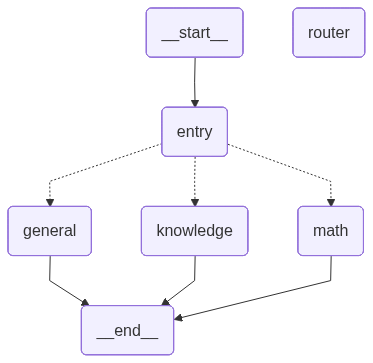

In [10]:
from IPython.display import Image, display
display(Image(graph.get_graph().draw_mermaid_png()))